# TensorFlow MNIST Autoencoder

## Dependencies and data

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

import time
import matplotlib.pyplot as plt
%matplotlib inline

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Model baseline

In [2]:
batch_size = 32
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 28*28], name="x")
y_ = tf.placeholder(tf.float32, shape=[None, 28*28], name="y_")

def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

## Build autoencoder

In [3]:
W1 = weight_variable([28*28,50], "W1")
b1 = bias_variable([50], "b1")
h1 = tf.nn.tanh(tf.matmul(x, W1) + b1)

W2 = weight_variable([50,50], "W2")
b2 = bias_variable([50], "b2")
h2 = tf.nn.tanh(tf.matmul(h1, W2) + b2)

# 'funnel' all the data information into just two dimensions
W3 = weight_variable([50,2], "W3")
b3 = bias_variable([2], "b3")
h3 = tf.nn.tanh(tf.matmul(h2, W3) + b3)

W4 = weight_variable([2,50], "W4")
b4 = bias_variable([50], "b4")
h4 = tf.nn.tanh(tf.matmul(h3, W4) + b4)

W5 = weight_variable([50,50], "W5")
b5 = bias_variable([50], "b5")
h5 = tf.nn.tanh(tf.matmul(h4, W5) + b5)

W6 = weight_variable([50,28*28], "W6")
b6 = bias_variable([28*28], "b6")
output = tf.matmul(h5, W6) + b6

## Objective: reconstruct input

We'll measure error here using the L2 loss function, which is

$$\frac{1}{2}(y-\hat y)^2$$

where $y$ is the training image and $\hat y$ is the model's prediction

In [4]:
loss = tf.nn.l2_loss( y_ - output ) / (28*28*batch_size)

## Model overview

In [7]:
total_parameters = 0 ; print "Model overview:"
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    print '\tvariable "{}" has {} parameters' \
        .format(variable.name, variable_parameters)
    total_parameters += variable_parameters
print "Total of {} parameters".format(total_parameters)

Model overview:
	variable "W1:0" has 39200 parameters
	variable "b1:0" has 50 parameters
	variable "W2:0" has 2500 parameters
	variable "b2:0" has 50 parameters
	variable "W3:0" has 100 parameters
	variable "b3:0" has 2 parameters
	variable "W4:0" has 100 parameters
	variable "b4:0" has 50 parameters
	variable "W5:0" has 2500 parameters
	variable "b5:0" has 50 parameters
	variable "W6:0" has 39200 parameters
	variable "b6:0" has 784 parameters
Total of 84586 parameters


## Train model

Takes a few minutes on my Macbook

In [8]:
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)
sess.run(tf.initialize_all_variables())
for i in range(50000):
    start = time.time()
    batch = mnist.train.next_batch(batch_size)
    step_loss, _ = sess.run([loss, train_step], feed_dict={x: batch[0], y_: batch[0]})
    if i%5000 == 0:
        print("step {}, training loss {:3f}, time/batch {:3f}".format(i, step_loss, time.time()-start))

step 0, training loss 0.052327, time/batch 0.023969
step 5000, training loss 0.028664, time/batch 0.002833
step 10000, training loss 0.027865, time/batch 0.002677
step 15000, training loss 0.027444, time/batch 0.002759
step 20000, training loss 0.026086, time/batch 0.002870
step 25000, training loss 0.028167, time/batch 0.002659
step 30000, training loss 0.026086, time/batch 0.003220
step 35000, training loss 0.023828, time/batch 0.002669
step 40000, training loss 0.023999, time/batch 0.003221
step 45000, training loss 0.022839, time/batch 0.003112


## Sample model

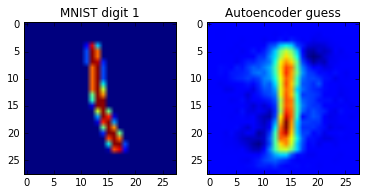

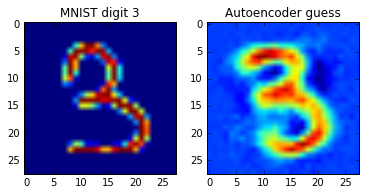

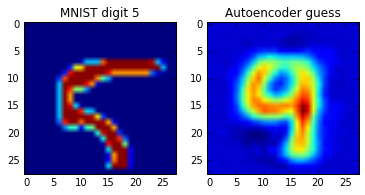

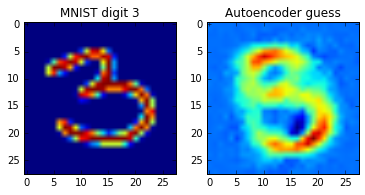

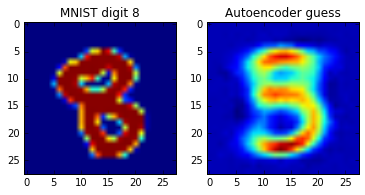

In [9]:
n_samples = 5
batch = mnist.train.next_batch(n_samples)
vec = sess.run(output, feed_dict={x: batch[0]})

for i in range(n_samples):
    in_img = np.reshape(batch[0][i,:],(28,28))
    out_img = np.reshape(vec[i,:],(28,28))
    
    plt.figure(i)    
    plt.subplot(121)
    plt.imshow(in_img) ; plt.title("MNIST digit {}".format(batch[1][i]))
    plt.subplot(122) ; plt.title("Autoencoder guess")
    plt.imshow(out_img)